In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get
import re
import unicodedata

In [ ]:
base_url = 'https://www.imdb.com'
section_url = 'https://www.imdb.com/list/ls001933214/?sort=list_order,asc&st_dt=&mode=detail&page=1'
#behind section_url there is a list of over 1000 movies I've seen. the list is on my private imdb account

In [ ]:
#scraping the movie links from my imdb seen movies list

def next_section_url(url): #function for extracting section link for the next page
    section_url = ''
    imdb_seen = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"}).text
    soup = BeautifulSoup(imdb_seen, "html.parser")
    pagination = soup.find('div', attrs={'class':'list-pagination'})
    if pagination.find('a', 'flat-button lister-page-next next-page') != None:
        section_url = base_url + pagination.find('a', 'flat-button lister-page-next next-page')['href']
    return section_url

def movie_links(url): #extracting the links for each movie's imdb page
    imdb_seen = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"}).text
    soup = BeautifulSoup(imdb_seen, "html.parser")
    sub_list = soup.find('div', attrs={'class':'lister list detail sub-list'})
    list_links = [base_url + dd.a['href'] for dd in sub_list.findAll('div', attrs={'class':'lister-item mode-detail'})]
    return list_links
    

In [ ]:
movie_links []
#appending the movie links list with seen movies links:

for i in range(11): #11 is for the eleven pages in my list of movies
    movie_links = movie_links + movie_links(section_url)
    section_url = next_section_url(section_url) #verciam sekanti puslapi
    
#saving the list of links
import pickle
pickling_on = open("seen_movies_links.pickle","wb")
pickle.dump(movie_links, pickling_on)

In [ ]:
#going to be scraping the information for each movie from the movie_links list

def get_keywords(url): #extracting the keyword list that imdb provides
    imdb_kw = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"}).text
    soup = BeautifulSoup(imdb_kw, "html.parser")
    kw_base = soup.find_all('td', 'soda sodavote')
    all_kw = [kw_base[i]['data-item-keyword'] for i in range(len(kw_base))]
    return all_kw

def get_actors(soup): #extracting either the first 10 actors from the actors list, or less if the movie had less
    actor_count = len(soup.find('table', 'cast_list').find_all('tr'))-1
    if actor_count<11:
        actor_list = [soup.find('table', 'cast_list').find_all('tr')[k+1].text.split('\n\n')[2][1:-2] for k in range(actor_count)]
    else:
        actor_list = [soup.find('table', 'cast_list').find_all('tr')[k+1].text.split('\n\n')[2][1:-2] for k in range(10)]
    actors = ','.join(actor_list)
    return actors


def movie_info(movie_url):
    imdb_m = get(movie_url, headers = {"Accept-Language": "en-US, en;q=0.5"}).text #with the headers parameter I am trying to avoid movie title translations
    soup_m = BeautifulSoup(imdb_m, "html.parser")
    title_and_year = soup_m.find('title').text[:-7]
    user_rating=soup_m.find('div', 'ratingValue').text[1:4]
    critic_rating=soup_m.find('div', 'titleReviewBar').contents[1].text[3:5]
    director = soup_m.find('div', 'credit_summary_item').text[11:]
    actors = get_actors(soup_m)
    keywords_link = base_url + soup_m.find('nobr').find('a')['href']
    keywords_list = get_keywords(keywords_link)
    keywords = ','.join(keywords_list)
    joined_info = {'title':title_and_year, 'user_rating':user_rating, 'critic_rating':critic_rating, 'director':director, 'actors':actors, 'keywords':keywords}
    return joined_info

In [ ]:
movie_attr=[]

#scraping movie attributes and appending to the list:
for i in range(len(movie_links)):
    informacija = movie_info(movie_links[i])
    movie_attr.append(informacija)

movie_frame = pd.DataFrame.from_dict(movie_attr)

In [ ]:
#doing some cleaning on the gathered dataset:

movie_frame['director'] = movie_frame['director'].apply(lambda x: x.strip()) #eliminating the whitespace chars
movie_frame['director'] = movie_frame['director'].apply(lambda x: x.split('(')[0]) #leaving only the first and main director of the movie
movie_frame['director'] = movie_frame['director'].apply(lambda x: x.split('|')[0]) 

#converting numeric columns from string to integer/float
#also normalizing numbers since for one column max is 10 and another max is 100 but the information type is the same
movie_frame['critic_rating'] = pd.to_numeric(movie_frame['critic_rating'], errors='coerce')
movie_frame['user_rating'] = pd.to_numeric(movie_frame['user_rating'], errors='coerce')
movie_frame['user_rating'] = movie_frame['user_rating'].apply(lambda x: x*10)
#adding columns with values of the difference between user given rating and movie critic rating
movie_frame['rating_diff_abs'] = 0
movie_frame['rating_diff_abs'] = (movie_frame['user_rating']-movie_frame['critic_rating']).abs()
#absolute difference
movie_frame['rating_diff'] = 0
movie_frame['rating_diff'] = movie_frame['user_rating']-movie_frame['critic_rating']

#splitting title and and year and creating new column for the year that the movie was released
movie_frame['year'] = 'y'
movie_frame['year'] = movie_frame['title'].apply(lambda x: x.split('(')[1])
movie_frame['year'] = movie_frame['year'].apply(lambda x: x[0:-1])
#eliminating the year part from the title
movie_frame['title'] = movie_frame['title'].apply(lambda x: x.split('(')[0][:-1]) 


#this below is a list of movies that are of preferece in regards to the whole movies list
outcome_true = pd.read_csv('names.csv', sep='delimiter', engine='python')
ones = np.array(outcome_true['Title'])

#create a new column in the movie data frame for the clasification of the movie. True-if the movie is of preference and False-if it is not
movie_frame['outcome'] = 0
movie_frame['outcome'] = filmu_freimas['title'].isin(ones)


In [20]:
movie_frame.tail()
#a glimpse of how the dataframe looks like:

,title,year,director,actors,critic_rating,user_rating,rating_diff,rating_diff_abs,keywords,outcome
1003,Shadow of a Doubt,1943,Alfred Hitchcock,"Teresa Wright,Joseph Cotten,Macdonald Carey,He...",94.0,79.0,-15.0,15.0,"murderer,serial killer,amateur detective,psych...",True
1004,Spindesys,1996,Scott Hicks,"Geoffrey Rush,Justin Braine,Sonia Todd,Chris H...",87.0,77.0,-10.0,10.0,"piano,pianist,australia,abuse,concert,concert ...",False
1005,Take This Waltz,2011,Sarah Polley,"Michelle Williams,Seth Rogen,Luke Kirby,Sarah ...",68.0,66.0,-2.0,2.0,"actress breaking typecast,husband wife relatio...",True
1006,Yosemite,2015,Gabrielle Demeestere,"James Franco,Everett Meckler,Troy Tinnirello,C...",59.0,48.0,-11.0,11.0,"f rated,grazed by bullet,grazed by a bullet,bu...",False
1007,The Sisters Brothers,2018,Jacques Audiard,"John C. Reilly,Joaquin Phoenix,Jake Gyllenhaal...",78.0,72.0,-6.0,6.0,"thieves on the run,shootout,brother brother re...",True


In [22]:
#a portion of EDA:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#extracting the numeric data from the dataframe
num_data = movie_frame[['critic_rating', 'user_rating', 'rating_diff', 'rating_diff_abs','outcome']]

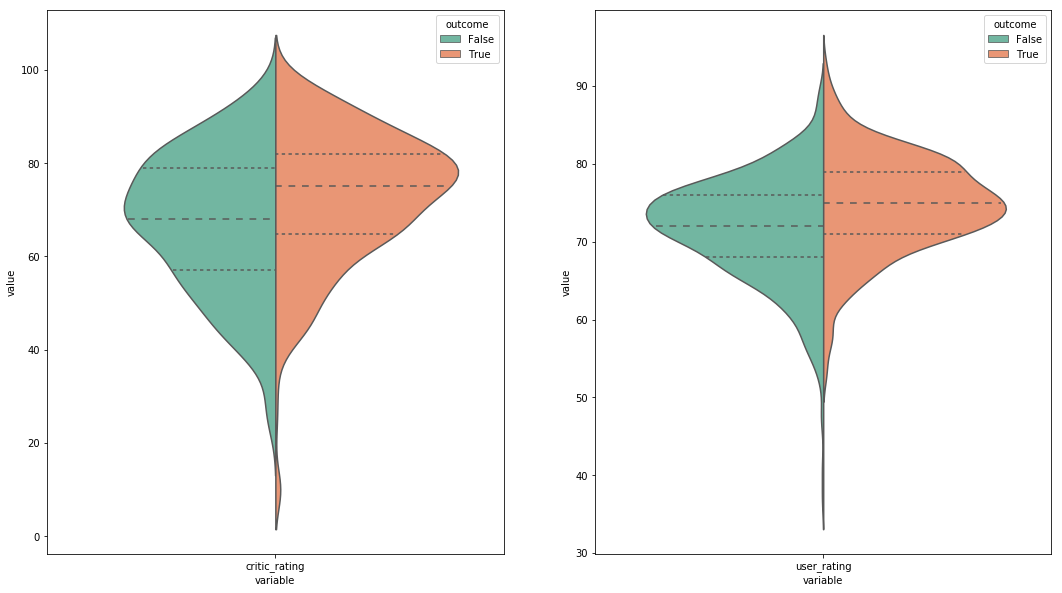

In [57]:
vp1 = pd.melt(num_data, id_vars='outcome', value_vars=['critic_rating'])
vp2 = pd.melt(num_data, id_vars='outcome', value_vars=['user_rating'])

fig, ax = plt.subplots(1,2, figsize=(18,10))

sns.violinplot(x='variable', y='value', hue='outcome', split=True, inner='quartile', palette="Set2", data=vp1, ax=ax[0])
sns.violinplot(x='variable', y='value', hue='outcome', split=True, inner='quartile', palette="Set2", data=vp2, ax=ax[1])

#from the violin plots it is visible that preferred movies have on average higher both critic rating and user rating. 
#in addition critic rating has lower variability for positive outcome movies



/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


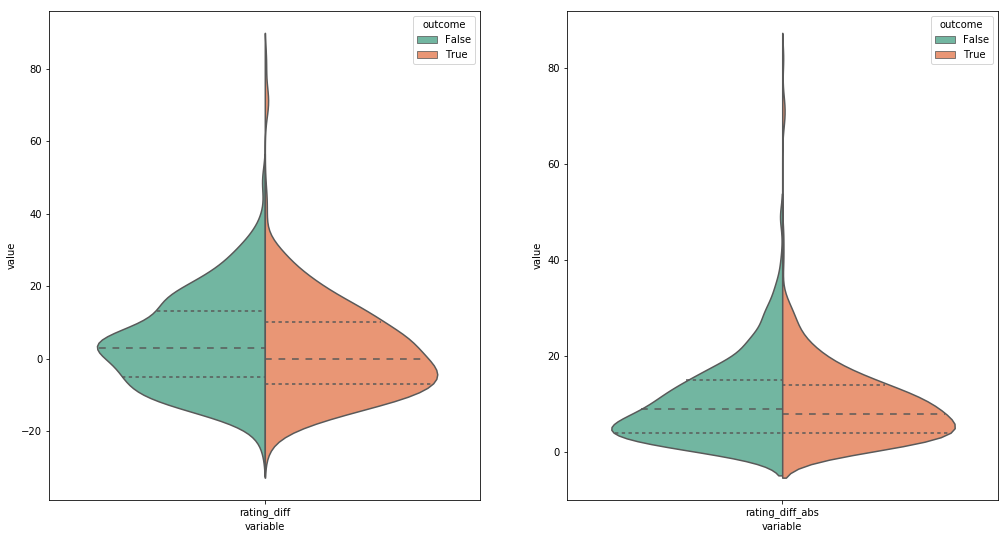

In [59]:
vp3 = pd.melt(num_data, id_vars='outcome', value_vars=['rating_diff'])
vp4 = pd.melt(num_data, id_vars='outcome', value_vars=['rating_diff_abs'])

fig, ax = plt.subplots(1,2, figsize=(17,9))

sns.violinplot(x='variable', y='value', hue='outcome', split=True, inner='quartile', palette="Set2", data=vp3, ax=ax[0])
sns.violinplot(x='variable', y='value', hue='outcome', split=True, inner='quartile', palette="Set2", data=vp4, ax=ax[1])
fig.show()

#

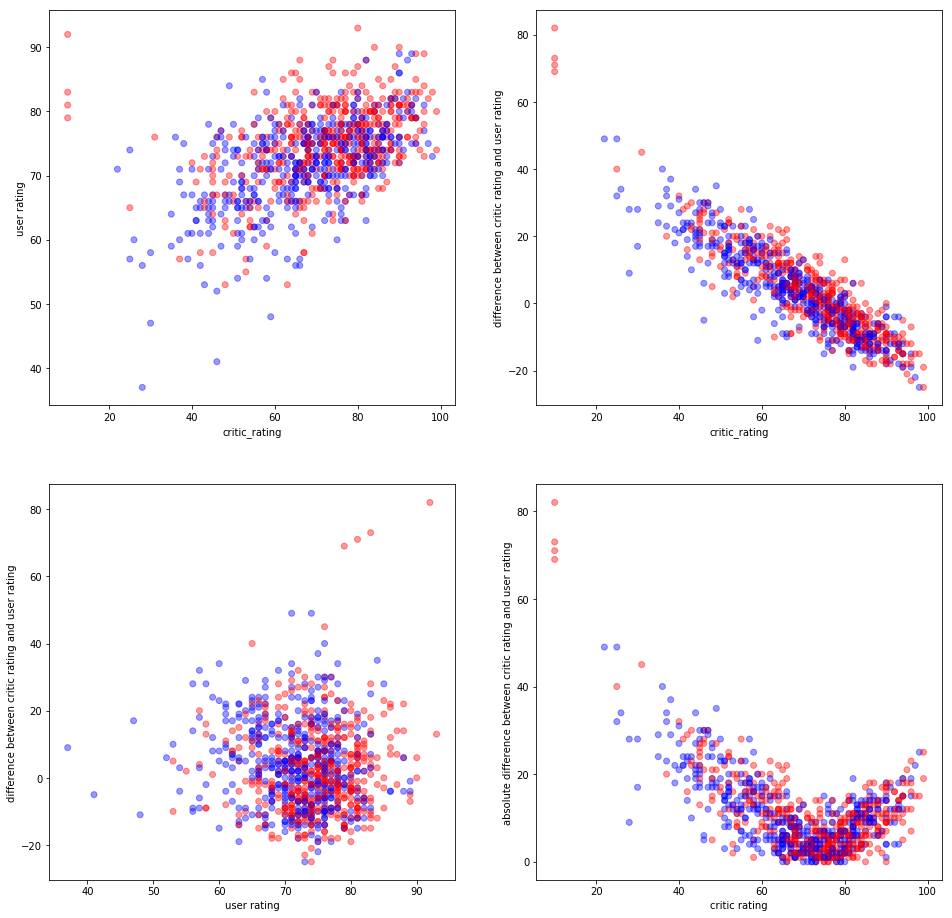

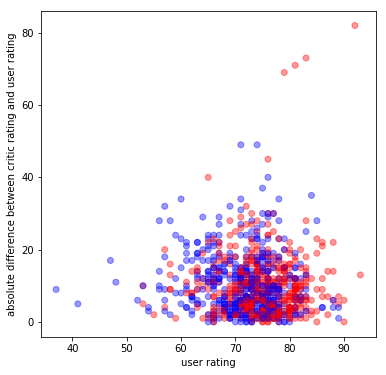

In [85]:
#trying to visualise if there are any relationships between the numeric data:
fig, ax = plt.subplots(2,2, figsize=(16,16)) 
colors1 = {True:'red', False:'blue'}

ax[0,0].scatter(num_data['critic_rating'], num_data['user_rating'], color=num_data['outcome'].apply(lambda x: colors1[x]), alpha=0.4)
ax[0,0].set_xlabel('critic_rating')
ax[0,0].set_ylabel('user rating')

ax[0,1].scatter(num_data['critic_rating'], num_data['rating_diff'], color=num_data['outcome'].apply(lambda x: colors1[x]), alpha=0.4)
ax[0,1].set_xlabel('critic_rating')
ax[0,1].set_ylabel('difference between critic rating and user rating')

ax[1,0].scatter(num_data['user_rating'], num_data['rating_diff'], color=num_data['outcome'].apply(lambda x: colors1[x]), alpha=0.4)
ax[1,0].set_xlabel('user rating')
ax[1,0].set_ylabel('difference between critic rating and user rating')

ax[1,1].scatter(num_data['critic_rating'], num_data['rating_diff_abs'], color=num_data['outcome'].apply(lambda x: colors1[x]), alpha=0.4)
ax[1,1].set_xlabel('critic rating')
ax[1,1].set_ylabel('absolute difference between critic rating and user rating')

fig, ax = plt.subplots(figsize=(6,6)) 
plt.scatter(num_data['user_rating'], num_data['rating_diff_abs'], color=num_data['outcome'].apply(lambda x: colors1[x]), alpha=0.4)
plt.xlabel('user rating')
plt.ylabel('absolute difference between critic rating and user rating')
plt.show()


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(-3, 5.5)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

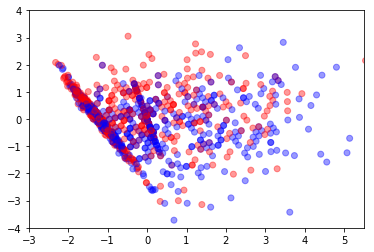

In [213]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Imputer

# Separating out the features
x_num = num_data[['critic_rating', 'user_rating', 'rating_diff', 'rating_diff_abs']].values
# Separating out the target
y = num_data[['outcome']].values
# Standardizing the features
imp = Imputer(strategy="mean", axis=0) #
rescaled_x = StandardScaler().fit_transform(imp.fit_transform(x_num))

pca = PCA(n_components=2, whiten=True)
pca.fit(rescaled_x)
pca_x = pca.transform(rescaled_x)



colors1 = {True:'red', False:'blue'}
plt.scatter(finalDf['pc1'], finalDf['pc2'], color=finalDf['outcome'].apply(lambda x: colors1[x]), alpha=0.4)
plt.ylim(-4,4)
plt.xlim(-3,5.5)

    

In [270]:
#visualizing the keywords:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
set(stopwords.words('english'))

#get the list of keywords and outcome related to them
keywords = movie_frame['keywords'].values
outcome = movie_frame['outcome'].astype(int)

[nltk_data] Downloading package punkt to /Users/gabaslava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [271]:
keywords[0]

'implied sex,swimsuit,serial killer,strong female lead,scantily clad female,cleavage,girl with glasses,river styx,poker the card game,musical instrument,english garden,fake drowning,fake parent,swimming pool,london england,death,ghost,surprise ending,death character,mysterious killer,murder investigation,buddy comedy,copycat killer,attempted murder,murder of a woman,card,tarot card,journalist,scoop,student,magician,magic,lord,investigation,strong female character,film blanc,written and directed by cast member,one word title,vaudevillian,topiary,tarot deck,stradivarius,social club,newspaper editor,manor house,grim reaper,french horn,combination lock,class differences,chinese box trick,blackmail,apparition,lie,rescue from drowning,reference to jack the ripper,mansion,attempted drowning,directed by co star,legs,cigar smoking,american in the uk,reporter,american abroad,party,deception,melodrama,murder,title spoken by character,plot twist,hairy chest,bare chested male'

In [286]:
#cleaning up the keywords, i.e. making them lower-case, taking out the unnecessary stopwords and eliminating samples that have less than 3 keywords
#set of words which will be eliminated from the keyword list:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', "you", "youre", "youve", "youll", "youd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "shes", 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'in', 'out', 'on', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'will', 'just', 'should', "shouldve", 'now', 'd', 'll', 'm', 'o', 're', 'aint', "arent", "couldnt", "didnt", "doesnt", "hadnt", "hasnt", "havent", "isnt", 'one', 'film', 'movie', 'one', 'character', 'time', 'son', 'daughter', 'word', 'title', 'reference', 'woman', 'new', 'york']

keywords_cleaned = []
outcome_cleaned = []
for i,e in zip(keywords,outcome):
    t1 = word_tokenize(i)
    t2 = [w for w in t1 if w.isalpha()]
    t3 = [w.lower() for w in t2] 
    t4 = [w for w in t3 if not w in stopwords]
    if len(t3)>2:
        keywords_cleaned.append(t4)
        outcome_cleaned.append(e)


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

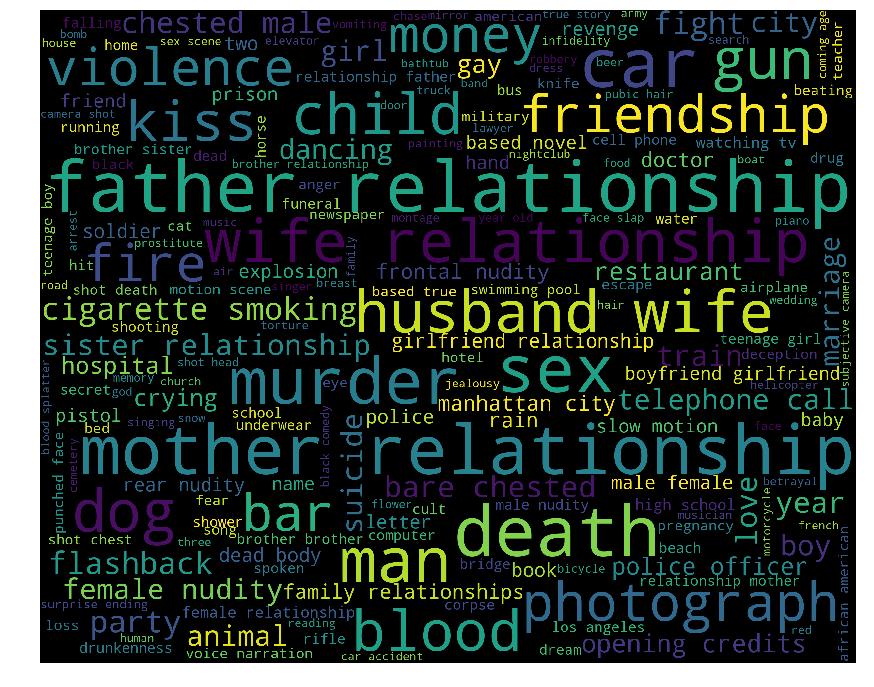

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

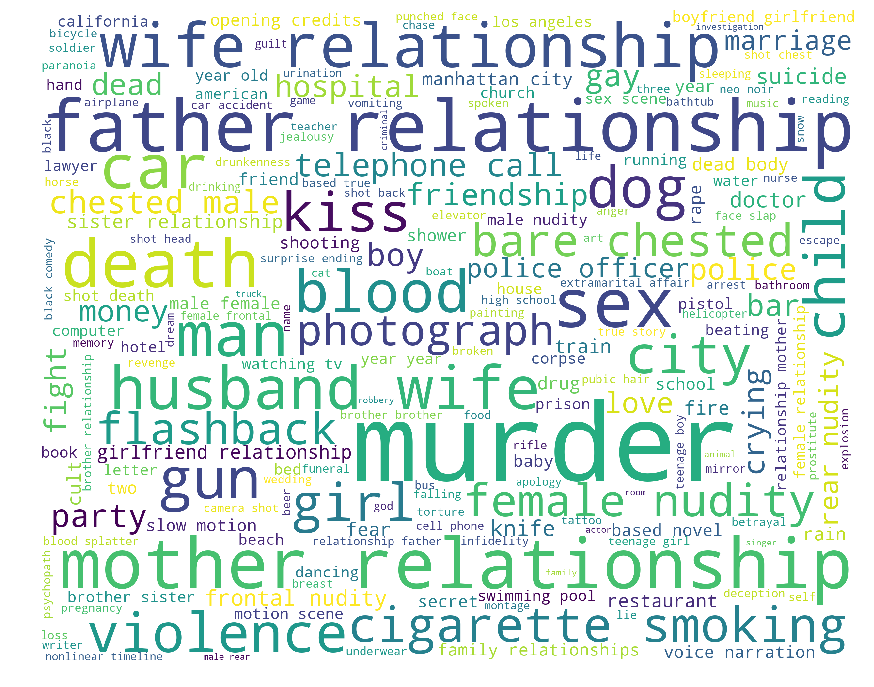

In [287]:
#trying to figure out if recurrent words from the keywords list are somewhat exclusive for either True or False outcome of a movie
from wordcloud import WordCloud

def wordcloud_draw(y, x, out=0, color = 'black'):
    indexes = np.where(np.array(y)==out)[0].tolist() #get the indexes for either true or false outcome
    words = [x[i] for i in indexes] #select the keywords related with either true or false outcome
    whole = [' '.join(i) for i in words]
    wordcloud = WordCloud(background_color=color,width=2500,height=2000).generate(' '.join(whole))
    plt.figure(1,figsize=(20, 12)) 
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


#black background graph will be for False outcome movies and white for True 
wordcloud_draw(outcome_cleaned, keywords_cleaned, out=0, color = 'black')
wordcloud_draw(outcome_cleaned, keywords_cleaned, out=1, color = 'white')

In [158]:
#prepareing to visualise actors and directors by the two groups

outcomes = movie_frame['outcome'].values
actors = [i.split(',') for i in movie_frame['actors'].values] #since every movie has a list of actors, I need to separate each actor from the list
actors_values = [] #the list will be filled with an actor ant their outcome for each movie they are in
for n in range(len(actors)):
    a_v = [actors[n], outcomes[n]] #re-joining the actors with their outcome
    for i in range(len(a_v[0])):
        actors_values.append([a_v[0][i],a_v[1]])
actor_frame = pd.DataFrame(actors_values, columns=['actor', 'outcome']) #actor and outcome dataframe
actor_frame['count'] = actor_frame.groupby(['actor'])['outcome'].transform('count') #adding count column for each actor for the number of times they appeared in the the movies dataset
actor_frame = actor_frame.loc[actor_frame['count']>9] #will be visualising the actors that appeared in 10 and more movies


directors_frame = director_frame = movie_frame[['director', 'outcome']]

In [159]:
import pixiedust 
display(actor_frame)

In [164]:
director_frame = movie_frame[['director', 'outcome']]
director_frame['count'] = director_frame.groupby(['director'])['outcome'].transform('count')
display(director_frame)


#scraping the web for movie reviews from review sites:
https://www.rogerebert.com
https://3brothersfilm.com
http://www.reelviews.net
https://www.nytimes.com/reviews/movies
https://brightlightsfilm.com
http://www.urbancinefile.com.au
http://alibi.com

In [ ]:
#functions for scraping each of the review sites if there's a link to in in the imdb page of the movie
def roger_ebert(eberts_f):
    reviews=[]
    if eberts_f is not None:
        links = [base_url + i['href'] for i in eberts_f]  
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            if window.find('h2', 'page-head') is not None: #in festival reviews this is empty, and i dont need festival reviews
                #window.find('article', {'class':'ad'}).decompose()
                raw_review = window.find('div', {'itemprop':'reviewBody'}).findAll('p')
                clean_review1 = [unicodedata.normalize("NFKD", re.sub('<[^<]+?>', '', i.text.strip())) for i in raw_review] #removing inside tags and \xa0 and .strip() removes \r\n from beginning or end 
                clean_review2 = [i.replace('\r\n', ' ').replace('\r', ' ').replace('\\', '') for i in clean_review1] #some \r\n did not vanish - now deleting the manual way
                clean_review = [i for i in clean_review2 if not i in 'Advertisement']
                reviews.append(' '.join(clean_review))
    return reviews


def brothers(brothers_f):
    reviews = []
    if brothers_f is not None:
        links = [base_url + i['href'] for i in brothers_f]  
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            raw_review = window.find_all('p')
            clean_review = [re.sub('<[^<]+?>', '', i.text) for i in raw_review[:-4]]
            reviews.append(' '.join(clean_review))
    return reviews



def reel_views(reel_f):
    reviews = []
    if reel_f is not None:
        links = [base_url + i['href'] for i in reel_f] 
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            if window.find('div', {'id':'reelContent'}) is not None:
                raw_review = window.find('div', {'id':'reelContent'}).find_all('p')
                clean_review1 = [unicodedata.normalize("NFKD", re.sub('<[^<]+?>', '', i.text.strip())) for i in raw_review] #removing \r\n
                clean_review = [i.replace('\r\n', '').replace('\\', '') for i in clean_review1] #removing manually
                reviews.append(' '.join(clean_review))
    return reviews



def ny_times(times_f):
    reviews = []
    if times_f is not None:
        links = [base_url + i['href'] for i in times_f] 
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            archive = window.find('span', 'kicker-label')
            regular_rev = window.find('p', 'css-1pdd3ka etcg8100')
            if (archive is not None) and (archive.text == 'Archives'):
                raw_review = window.find_all('p', 'story-body-text story-content')
                clean_review = [i.text.strip() for i in raw_review[:-1]]
                #clean_review = [i.replace('\\', '') for i in clean_review1]
                reviews.append(' '.join(clean_review))
            elif (regular_rev is not None) and (regular_rev.text == 'Movie Review'):
                raw_review = window.find('section', {'name':'articleBody'}).find_all('p', 'css-1ygdjhk e2kc3sl0')
                clean_review = [i.text.strip() for i in raw_review[:-1]]
                #clean_review = [i.replace('\\', '') for i in clean_review1]
                reviews.append(' '.join(clean_review))      
    return reviews

                
def bright_lights(bl_f):
    reviews = []
    if bl_f is not None:
        links = [base_url + i['href'] for i in bl_f]  
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            raw_review = window.find('div', 'text').text.strip()
            clean_review = raw_review.replace('\r\n', '').replace('\n', '')
            reviews.append(clean_review)
    return reviews


def alibi(alibi_f):
    reviews = []
    if alibi_f is not None:
        links = [base_url + i['href'] for i in alibi_f] 
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            clean_review = window.find('div', {'itemprop':'reviewBody'}).text
            reviews.append(clean_review)
    return reviews     
    
    
def cinefile(cinefile_f):
    reviews = []
    if cinefile_f is not None:
        links = [base_url + i['href'] for i in cinefile_f] 
        for i in range(len(links)):
            window = BeautifulSoup(get(links[i]).text, "html.parser")
            b_tags = window.find('font', {'class':'articleBody'}).find_all('b') #eliminate b tags
            for i in b_tags:
                i.decompose()
            raw_review = window.find('font', {'class':'articleBody'}).text.strip()
            clean_review = raw_review.replace('\r', '').replace('\n', '')
            reviews.append(clean_review)
    return reviews



In [ ]:
#function for gathering the movie title and all available reviews
def the_reviews(url):
    imdb_m = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"}).text 
    soup_m = BeautifulSoup(imdb_m, "html.parser")
    title = soup_m.find('title').text[:-7] #movie title
    metas = soup_m.find('div','titleReviewBarItem titleReviewbarItemBorder').find_all('a')[1]['href']
    if metas is not None:
        metas_soup = BeautifulSoup(get(url+metas).text, "html.parser")
        eberts_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['Roger Ebert', 'Rogerebert.com']])
        brothers_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['3 Brothers']])
        reel_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['ReelViews']])
        times_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['New York Times']])
        bl_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['Bright Lights Film Journal']])
        alibi_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['Alibi.com']])
        cinefile_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['Urban Cinefile']])
        flick_f = metas_soup.find_all('a', text = [re.compile(p) for p in ['FlickFilosopher.com']])
        
        lights_reviews = bright_lights(bl_f)
        alibi_reviews = alibi(alibi_f)
        cinefile_reviews = cinefile(cinefile_f)
        ebert_reviews = roger_ebert(eberts_f)
        brothers_reviews = brothers(brothers_f)
        reel_reviews = reel_views(reel_f)
        times_reviews = ny_times(times_f)

    info = {'title':title, 'ebert':ebert_reviews, '3brothers':brothers_reviews, 'reel':reel_reviews, 'nytimes':times_reviews, 'bright_lights':lights_reviews, 'alibi':alibi_reviews, 'cinefile':cinefile_reviews}
    return info



review_frame=[]
for i in movie_links:
    review_frame.append(the_reviews(i))

In [ ]:
# building a list consisting of reviews and outcome solely:
review_and_outcome = []

for i in review_frame:
    if len(i['3brothers'])>0:
        skaicius = len(i['3brothers']) 
        for k in range(skaicius):
                review_and_outcome.append([i['3brothers'][k], i['outcome']])
    if len(i['ebert'])>0:
        skaicius = len(i['ebert']) 
        for k in range(skaicius):
            review_and_outcome.append([i['ebert'][k], i['outcome']])
    if len(i['nytimes'])>0:
        skaicius = len(i['nytimes']) 
        for k in range(skaicius):
            review_and_outcome.append([i['nytimes'][k], i['outcome']])
    if len(i['reel'])>0:
        skaicius = len(i['reel']) 
        for k in range(skaicius):
            review_and_outcome.append([i['reel'][k], i['outcome']])
    if len(i['bright_lights'])>0:
        skaicius = len(i['bright_lights']) 
        for k in range(skaicius):
            review_and_outcome.append([i['bright_lights'][k], i['outcome']])
    if len(i['alibi'])>0:
        skaicius = len(i['alibi']) 
        for k in range(skaicius):
            review_and_outcome.append([i['alibi'][k], i['outcome']])
    if len(i['cinefile'])>0:
        skaicius = len(i['cinefile']) 
        for k in range(skaicius):
            review_and_outcome.append([i['cinefile'][k], i['outcome']])
        
df = pd.DataFrame(review_and_outcome, columns=['review', 'outcome'])
df.to_csv('review_and_outcome.csv', index=False)

In [14]:
#tokenizing the review texts:

text = [i[0] for i in review_and_outcome] 
outcome = [i[1] for i in review_and_outcome]
stopwords_set = ['i', 'me', 'my', 'we', 'our', 'ours', "you", "youre", "youve", "youll", "youd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "shes", 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'to', 'from', 'up', 'in', 'out', 'on', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'll', 'will', 'just', 'should', "shouldve", 'now', 'd', 'm', 'o', 're', 'aint']


tokenized_text = []
for i in text:
    t1 = word_tokenize(i) #separating all the words
    t2 = [w.lower() for w in t1] #converting to lower-case
    t3 = [w for w in t2 if w.isalpha()] #remove all elements that are not alpahbetical
    t0 = [w for w in t3 if not w in stopwords_set]
    tokenized_text.append(t0)
    
#getting rid of the the texts that have 100 words and less
X=[]
Y=[]
for i,e in zip(tokenized_text,outcome):
    if len(i)>100:
        X.append(i)
        Y.append(e)

In [15]:
#sample now consists of 2.2K reviews: 1144 categorized as True and 1057 as False
from collections import Counter
print(Counter(Y))
len(X), len(Y) 

Counter({True: 1144, False: 1057})


(2201, 2201)

In [16]:
max_len = max([len(i) for i in X])
min_len = min([len(i) for i in X])
mean_x = np.mean([len(i) for i in X])
std_x = np.std([len(i) for i in X])
total_x = sum([len(i) for i in X]) #total word count/non-unique

max_len, min_len, mean_x, std_x, total_x 
#longest review consists of almost 6K words, shortest-101words
#on average review has 492words with std of 246
#total word count for all reviews combined is over 1M)

(5981, 101, 492.1104043616538, 246.5309851861547, 1083135)

In [25]:
#this part will be about vectorizing unique words so every meaning has it's own dimentionality
import gensim

model=gensim.models.Word2Vec(sentences=X, size=100, window=7, min_count=10) 
#size is vector dimentionality, i.e. each unique word will be represented with a vector of 100 numbers
#window is about how many closest words will be taken into account while prividing the vector
#min_count=10 means that only the words that appear in whole text corpus 10 or more times will be vectorized and put up in the dictionary
model.train(X, total_examples=len(X), epochs=2) #20total
unique_words=list(model.wv.vocab) 
print(len(unique_words)) #there are 12770 unique words in the whole text corpus that appear 10 or more times. Remember that total word count is over 1M

12770


In [27]:
model.wv.most_similar('man'), model.wv.most_similar('profound'), model.wv.most_similar('politics')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([('woman', 0.8239573836326599),
  ('boy', 0.6949129700660706),
  ('person', 0.6590011119842529),
  ('soul', 0.645129919052124),
  ('girl', 0.6423314809799194),
  ('kid', 0.6041820645332336),
  ('name', 0.6026101112365723),
  ('victim', 0.6024134159088135),
  ('child', 0.5958261489868164),
  ('hero', 0.595077633857727)],
 [('underlying', 0.9650431871414185),
  ('intellectual', 0.9605517387390137),
  ('confronting', 0.9573075771331787),
  ('truths', 0.9569254517555237),
  ('specific', 0.9541032314300537),
  ('uplifting', 0.9517643451690674),
  ('explore', 0.9498921632766724),
  ('observation', 0.9488849639892578),
  ('philosophical', 0.9445406794548035),
  ('essential', 0.9426624774932861)],
 [('sin', 0.915941059589386),
  ('implications', 0.9051206111907959),
  ('crimes', 0.9015991687774658),
  ('racism', 0.887448787689209),
  ('greed', 0.8864399194717407),
  ('legitimate', 0.885558009147644),
  ('meditation', 0.8853869438171387),
  ('fundamentally', 0.8843704462051392),
  ('theory', 0

In [316]:
model.wv.most_similar('woman'),model.wv.most_similar('think'), model.wv.most_similar('profound'), model.wv.most_similar('politics')
#checking what words have similar vectorization to relationship, woman, politics or profound

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


([('girl', 0.6524187326431274),
  ('boy', 0.6351219415664673),
  ('man', 0.610416054725647),
  ('waitress', 0.5972503423690796),
  ('lady', 0.5863891839981079),
  ('teenager', 0.5826882123947144),
  ('child', 0.579138457775116),
  ('vera', 0.5745306015014648),
  ('nurse', 0.5706342458724976),
  ('person', 0.568467378616333)],
 [('say', 0.7306560277938843),
  ('anyway', 0.7224564552307129),
  ('guess', 0.7057949304580688),
  ('ask', 0.6900709867477417),
  ('thinking', 0.6885706186294556),
  ('anybody', 0.6762778759002686),
  ('said', 0.6698130369186401),
  ('thought', 0.6693036556243896),
  ('know', 0.6610050201416016),
  ('believe', 0.6609405279159546)],
 [('underlying', 0.890788733959198),
  ('truthful', 0.8469385504722595),
  ('rewarding', 0.8319370150566101),
  ('exploration', 0.8302242755889893),
  ('confronting', 0.8238725662231445),
  ('intellectual', 0.8154534697532654),
  ('undercurrent', 0.8094648122787476),
  ('perception', 0.8082907199859619),
  ('profoundly', 0.806296288967

In [28]:
#saving the the word-vectors:
filename = 'gensim_word2vec.csv'
model.wv.save_word2vec_format(filename, binary=False)

In [29]:
#creating a dictionary of words and their vectors
def word_and_vec(vectors_file):
    embeddings = {}
    f = open(vectors_file)
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings[word] = vector
    f.close()
    return embeddings

word_embeddings = word_and_vec('gensim_word2vec.csv')



In [30]:
#vectorize the sample texts:

#to standartize the texts they will all be made into 200x100 matrixes, i.e. texts that have less than 200words after vectorization(that means that some words are cut instantlhy because they don't have a vector to represent them) will be padded extended with zeros and longer texts will be cut. 100 stands for the vector length
vectorized_corpora=np.zeros((len(X), 200, 100)) 

for review,i in zip(X,range(len(X))):
    vectorized_reveiew = np.array([word_embeddings[word] for word in review if word in unique_words]) 
    if len(vectorized_reveiew)<200:
        vectorized_reveiew.resize((200,100), refcheck=False)
        vectorized_corpora[i]=np.array(vectorized_reveiew)
    else:
        vectorized_corpora[i]=vectorized_reveiew[:200]

In [ ]:
vec_words_true = i
PCA(n_components=5).fit(X_scaled)

In [33]:

word_vectors_true = []
word_vectors_false = []

for i,e in zip(vectorized_corpora,Y):
    for word in i:
        if all(np.array(word)!=0):
            if e==True:
                word_vectors_true.append(word)
            elif e==False:
                word_vectors_false.append(word)

len(word_vectors_true), len(word_vectors_false)            

#lists include 227258 word_vectors that were in reviews marked as True and 209456 word_vectors that were in reviews marked False


(227231, 209438)

In [123]:
from sklearn.decomposition import PCA


true_sample = random.sample(word_vectors_true, 20000)
pca_true = PCA(n_components=50).fit_transform(true_sample)

false_sample = random.sample(word_vectors_false, 20000)
pca_false = PCA(n_components=50).fit_transform(false_sample)

ex_variance_true=np.var(pca_true,axis=0)
ex_variance_false=np.var(pca_false,axis=0)
ex_variance_ratio_true = ex_variance_true/np.sum(ex_variance_true)
ex_variance_ratio_false = ex_variance_false/np.sum(ex_variance_false)

ex_variance_ratio_true, ex_variance_ratio_false

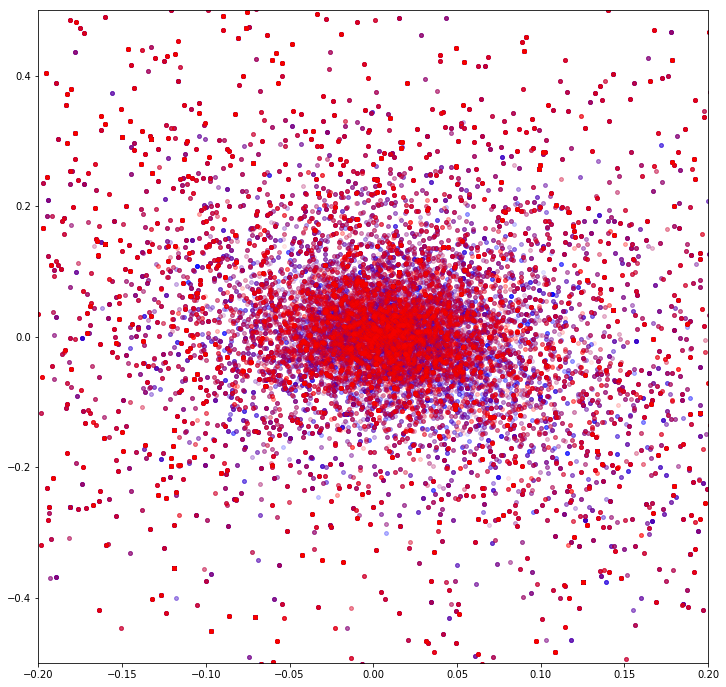

In [87]:

#fig = plt.figure(figsize=(12,12))
#ax1 = fig.add_subplot(111)
#ax1.scatter([i[0] for i in false_sample], [i[1] for i in false_sample], s=15, c='b', marker="o", label='false', alpha=0.1)
#ax1.scatter([i[0] for i in true_sample], [i[1] for i in true_sample], s=15, c='r', marker="o", label='true', alpha=0.09)
#ax1.set_ylim(-0.5,0.5)
#ax1.set_xlim(-0.2,0.2)
#plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)

#true_sample = random.sample(word_vectors_true, 20000)
tsne_results_true = tsne.fit_transform(pca_true)

#false_sample = random.sample(word_vectors_false, 20000)
tsne_results_false = tsne.fit_transform(pca_false)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.061s...
[t-SNE] Computed neighbors for 20000 samples in 35.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

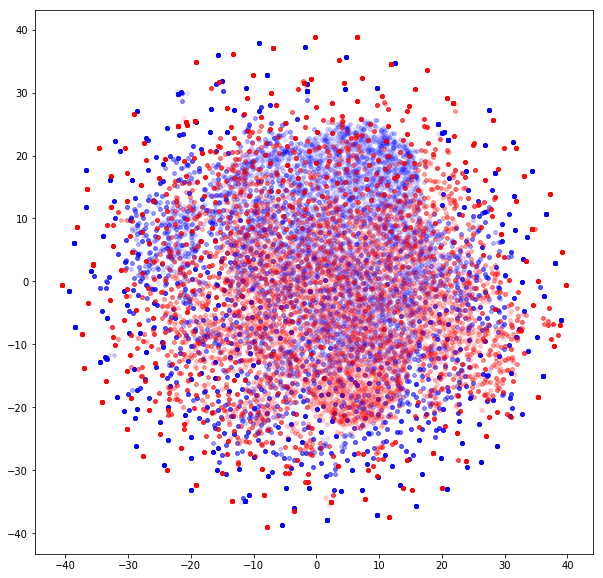

In [107]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in tsne_results_true], [i[1] for i in tsne_results_true], s=15, c='b', marker="o", label='false', alpha=0.1)
ax1.scatter([i[0] for i in tsne_results_false], [i[1] for i in tsne_results_false], s=15, c='r', marker="o", label='true', alpha=0.1)
#ax1.set_ylim(-0.5,0.5)
#ax1.set_xlim(-0.2,0.2)
plt.show()

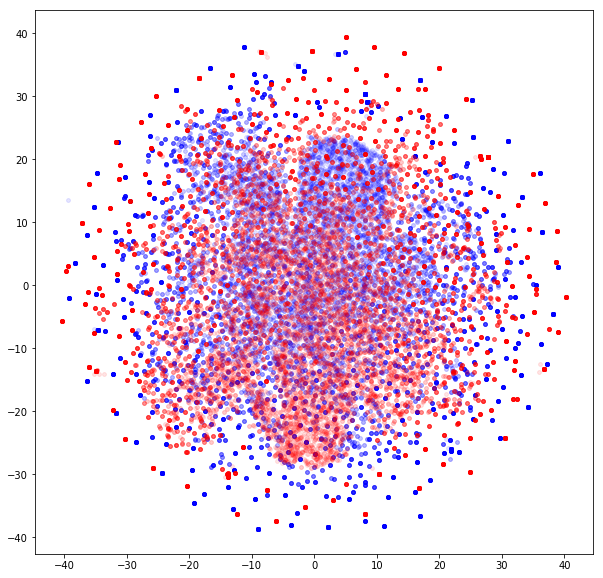

In [117]:
#with PCA that had 30dimentions
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in tsne_results_true], [i[1] for i in tsne_results_true], s=15, c='b', marker="o", label='false', alpha=0.1)
ax1.scatter([i[0] for i in tsne_results_false], [i[1] for i in tsne_results_false], s=15, c='r', marker="o", label='true', alpha=0.1)
#ax1.set_ylim(-0.5,0.5)
#ax1.set_xlim(-0.2,0.2)
plt.show()

In [ ]:
#with PCA that had 20dimentions
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter([i[0] for i in tsne_results_true], [i[1] for i in tsne_results_true], s=15, c='b', marker="o", label='false', alpha=0.1)
ax1.scatter([i[0] for i in tsne_results_false], [i[1] for i in tsne_results_false], s=15, c='r', marker="o", label='true', alpha=0.1)
#ax1.set_ylim(-0.5,0.5)
#ax1.set_xlim(-0.2,0.2)
plt.show()